# A. Seq2Seq Chatbot with Keras

The purpose here is to build and train a seq2seq chatbot model with Keras. A sequence to sequence model is composed of 2 main components: an encoder RNN and a decoder RNN. From a high level, the encoder’s job is to encapsulate the information of the input text into a fixed representation. The decoder’s job is to then take that representation, and generate a variable length text that best responds to it.

**Data:**    
The data that will be used to train the model is the Cornell Movie--Dialogs Corpus, which can be found through the following link: https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

From this dataset, movie_lines.txt will be used, which contains 220,579 conversational exchanges between 10,292 pairs of movie characters.

First, the data will be prepared for the model.

In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers, activations, models, preprocessing, utils
import os
import yaml
import requests, zipfile, io
import pandas as pd
import string
import operator
import codecs
import re

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Import, clean and preprocess the data

In [2]:
MAX_LEN = 20
#MAX_SAMPLES = 50000

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    #creating a space between a word and the punctuation following it
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    #replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence


def load_conversations():
    #dictionary of line id to text
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        #get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            #if wish to limit sample size specify MAX_SAMPLES and uncomment the below
            #if len(inputs) >= MAX_SAMPLES:
               # return inputs, outputs
    return inputs, outputs


context, target = load_conversations()

In [5]:
print('Sample context: {}'.format(context[1]))
print('Sample target: {}'.format(target[1]))

Sample context: well , i thought we d start with pronunciation , if that s okay with you .
Sample target: not the hacking and gagging and spitting part . please .


In [6]:
bos = "<BOS> "
eos = " <EOS>"
final_target = [bos + convo + eos for convo in target] 
encoder_text = context
decoder_text = final_target

In [7]:
len(encoder_text), len(decoder_text)

(221616, 221616)

### Make the vocabulary, tokenise and pad sequences

Here, a dictionary will be created that maps words to a unique integer (index), and an inverse dictionary of the integers (index) to word - an inverse dictionary is created due to the need to do inverse mapping in the implementation of the seq2seq model.

In [8]:
full_text = encoder_text + decoder_text

In [9]:
from keras.preprocessing.text import Tokenizer
VOCAB_SIZE = 15000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)

tokenizer.fit_on_texts(full_text)
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= VOCAB_SIZE} 

Using TensorFlow backend.


In [12]:
word_index = tokenizer.word_index
len(word_index)

15000

In [17]:
encoder_sequences = tokenizer.texts_to_sequences(encoder_text)
decoder_sequences = tokenizer.texts_to_sequences(decoder_text)

In [21]:
from keras.preprocessing.sequence import pad_sequences
encoder_input_data = pad_sequences(encoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')
decoder_input_data = pad_sequences(decoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')

In [22]:
import numpy as np
num_samples = len(encoder_sequences)
decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")

In [23]:
for i, seqs in enumerate(decoder_input_data):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data[i][j][seq] = 1.
            
print(decoder_output_data.shape)

(221616, 20, 15000)


### Word embedding with Numberbatch

These embeddings can be downloaded through the following link: https://github.com/commonsense/conceptnet-numberbatch

In [24]:
#load and read in numberbatch
embeddings_index = {}
with open('numberbatch/numberbatch-en-19.08.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print("Numberbatch Loaded")

Numberbatch Loaded


In [25]:
embedding_dimension = 300

def embedding_matrix_creator(embedding_dimension, word_index):
    embedding_matrix = np.zeros((len(word_index)+1, embedding_dimension))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
          #words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [26]:
embedding_matrix = embedding_matrix_creator(300, word_index=word_index)

## 2. Defining the Encoder-Decoder model

The model will have Embedding, LSTM and Dense layers. The configuration is as follows:
+ 2 Input Layers - one for encoder_input_data and one for decoder_input_data.
+ Embedding layer - for converting token vectors to fix sized dense vectors (include the mask_zero = True argument)
+ LSTM layer - provide access to Long-Short Term cells.

Working :
+ Encoder_input_data comes in the Embedding layer (encoder_embedding).
+ Output of Embedding layer goes to the LSTM cell which produces 2 state vectors (h and c which are encoder_states). These states are set in the LSTM cell of the decoder.
+ Decoder_input_data comes in through Embedding layer.
+ Embeddings goes in LSTM cell (which had the states) to produce seqeunces.

In [27]:
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model
from keras.layers import Embedding

In [28]:
embed_layer = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=300, trainable=True,)
embed_layer.build((None,))
embed_layer.set_weights([embedding_matrix])

In [29]:
HIDDEN_DIM = 300

#encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = embed_layer(encoder_inputs)
encoder_outputs, enc_state_h, enc_state_c = LSTM(HIDDEN_DIM, return_state=True)(encoder_embedding)
encoder_states = [enc_state_h, enc_state_c]

#decoder
decoder_inputs = Input(shape=(None, ))
decoder_embedding = embed_layer(decoder_inputs)
decoder_lstm = LSTM(HIDDEN_DIM , return_state=True , return_sequences=True)
decoder_outputs , _ , _ = decoder_lstm (decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(VOCAB_SIZE, activation='softmax') 
output = decoder_dense (decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], output)

#define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

#define inference decoder
decoder_state_input_h = Input(shape=(300,))
decoder_state_input_c = Input(shape=(300,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, dec_state_h, dec_state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [dec_state_h, dec_state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

model.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    4500300     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 300), (None, 721200      embedding_1[0][0]          

## 3. Training the model

In [30]:
BATCH_SIZE = 32
EPOCHS = 5

In [31]:
history = model.fit([encoder_input_data, decoder_input_data], 
                     decoder_output_data, 
                     epochs = EPOCHS, 
                     batch_size = BATCH_SIZE)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
221616/221616 [==============================] - 2729s 12ms/step - loss: 0.4624 - accuracy: 0.9116
Epoch 2/5
221616/221616 [==============================] - 2887s 13ms/step - loss: 0.0122 - accuracy: 0.9484
Epoch 3/5
221616/221616 [==============================] - 3055s 14ms/step - loss: 5.7053e-04 - accuracy: 0.9499
Epoch 4/5
221616/221616 [==============================] - 3077s 14ms/step - loss: 9.7514e-05 - accuracy: 0.9500
Epoch 5/5
221616/221616 [==============================] - 3092s 14ms/step - loss: 2.2899e-05 - accuracy: 0.9500


## 4. Visualising model learning history

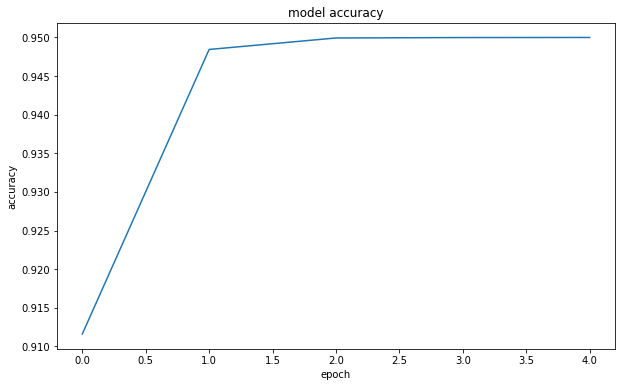

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot accuracy of model learning history
plt.figure(figsize = (10, 6))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

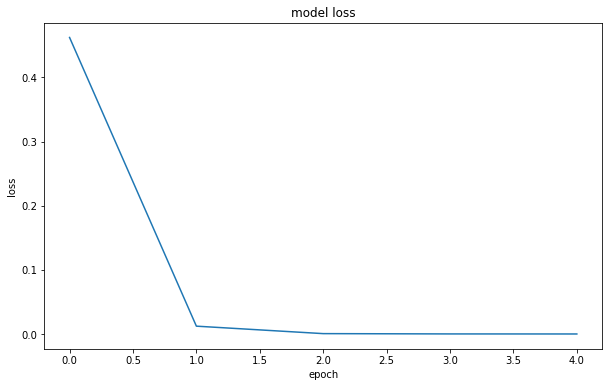

In [33]:
#plot loss of model learning history
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [34]:
#save model
json_string = model.to_json()
open('seq2seq.json', 'w').write(json_string)
model.save_weights('seq2seq_weights.h5')
print("Model saved")

Model saved


## 5. Testing the model

1. A question is taken as input and state values are predicted using enc_model.
2. State values are set in the decoder's LSTM.
3. A sequence is generated, which contains the `<start>` element.
4. This sequence is inputted in the dec_model.
5. The `<start>` element is replaced with the element predicted by the dec_model and state values updated.
6. The above steps are carried out iteratively until the `<end>` tag or the maximum answer length is hit.

In [ ]:
def str_to_tokens( sentence : str ):
    sentence = preprocess_sentence(sentence)
    encoder_sentence = tokenizer.texts_to_sequences(sentence)
    encoder_input_sentence = pad_sequences(encoder_sentence, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')
    return encoder_input_sentence

In [ ]:
#encoder and decoder inference models defined previously
for _ in range(10):
    states_values = encoder_model.predict(str_to_tokens(input('Enter question : ' )))
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['bos']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs, h, c = decoder_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])

        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                decoded_translation += ' {}'.format(word)
                sampled_word = word
        
        #if sampled_word == 'eos' or len(decoded_translation.split()) > MAX_LEN:
        if sampled_word_index == tokenizer.word_index['eos'] or len(decoded_translation.split()) > MAX_LEN:
            stop_condition = True
            
        empty_target_seq = np.zeros((1, 1))  
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c] 

    print(decoded_translation)

# B. Transformer Chatbot by Bryan M. Li

The article for this chatbot is found on Medium: https://medium.com/tensorflow/a-transformer-chatbot-tutorial-with-tensorflow-2-0-88bf59e66fe2

It is reproduced and adapted here as I think it is a great example of a more complicated, yet elegant, chatbot using Tensorflow, and would like to refer back to it.

As other seq2seq models, the Transformer chatbot also contains an encoder and decoder. But instead of recurrent or convolution layers, it uses multi-head attention layers, which consist of multiple scaled dot-product attention.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.0.0


## 1. Hyperparameters

For speed and simplicity, values for num_layers, d_model, and units have been reduced, as well as number of samples to preprocess.

In [2]:
# Maximum sentence length
MAX_LENGTH = 20

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

## 2. Load and preprocess data

To increase speed and simplicity, maximum number of training samples will be limited using MAX_SAMPLES. Maximum length of sentence will be limited to MAX_LENGTH=20.

The dataset is preprocessed in the following order:
1. Extract MAX_SAMPLES conversation pairs into list of questions and answers.
2. Preprocess each sentence by removing special characters in each sentence.
3. Build tokeniser (map text to ID and ID to text) using TensorFlow Datasets SubwordTextEncoder.
4. Tokenise each sentence and add START_TOKEN and END_TOKEN to indicate the start and end of each sentence.
5. Filter out sentence that has more than MAX_LENGTH tokens.
6. Pad tokenised sentences to MAX_LENGTH

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    #creating a space between a word and punctuation following it
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


def load_conversations():
    # dictionary of line id to text
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        
        # get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            #if wish to limit sample size specify MAX_SAMPLES and uncomment the below
            #if len(inputs) >= MAX_SAMPLES:
                #return inputs, outputs
    return inputs, outputs

questions, answers = load_conversations()

In [5]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: i really , really , really wanna go , but i can t . not unless my sister goes .
Sample answer: i m workin on it . but she doesn t seem to be goin for him .


In [6]:
#build tokeniser using tfds for questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

#define start and end tokens for start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

#vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [7]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 312, 2, 312, 2, 152, 412, 186, 2, 43, 4, 39, 8006, 3, 36, 915, 30, 1478, 3314, 1]


In [8]:
#tokenise, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        #tokenise sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        #check tokenised sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    #pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)

In [9]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8148
Number of samples: 128010


In [10]:
#decoder inputs use previous target as input; remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 20), dec_inputs: (None, 19)}, {outputs: (None, 19)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


## 3. Defining the model

### Attention

The scaled dot-product attention function takes 3 inputs: Q (query), K (key), V (value). 

Softmax normalisation is applied on the key, so its values decide the amount of importance given to the query. The output represents the multiplication of the attention weights and value. This ensures that the words we want to focus on are kept as is and irrelevant words are flushed out.

In [12]:
#function to calculate attention weights

def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    #scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    #add mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    #softmax normalised on last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

**Multi-head Attention Layer**

The Sequential models allow the building of models very quickly by simply stacking layers on top of each other. But for more complicated and non-sequential models, the Functional API and Model subclassing are needed. The tf.keras API allows the mixing and matching of different API styles. Model subclassing has the capability for debugging. A breakpoint can be set in the call() method and values observed for each layer’s inputs and outputs like a numpy array, and this makes debugging a lot simpler.

Here, the Model subclassing is used to implement the MultiHeadAttention layer.

Multi-head attention consists of four parts:
1. Linear layers and split into heads.
2. Scaled dot-product attention.
3. Concatenation of heads.
4. Final linear layer.

Each multi-head attention block takes a dictionary as input, which consists of query, key and value. When using Model subclassing with Functional API, the input(s) has to be kept as a single argument, hence the query query, key and value need to wrapped as a dictionary. The inputs are then put through dense layers and split up into multiple heads.    

scaled_dot_product_attention() defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated and put through a final dense layer.

Instead of one single attention head, query, key, and value are split into multiple heads as it allows the model to jointly attend to information at different positions from different representational spaces. After the split, each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        #linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        #split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        #scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        #concatenation of heads
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        #final linear layer
        outputs = self.dense(concat_attention)

        return outputs

### Transformer

**Masking:** create_padding_mask and create_look_ahead are helper functions to creating masks to mask out padded tokens, these helper functions will be used as Lambda layers. Mask all pad tokens (value 0) in the batch to ensure the model does not treat padding as input.

In [14]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    #(batch_size, 1, 1, sequence length)    
    return mask[:, tf.newaxis, tf.newaxis, :]

In [15]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

**Positional encoding:**

Since this model does not contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

In [16]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
    
        #apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        #apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

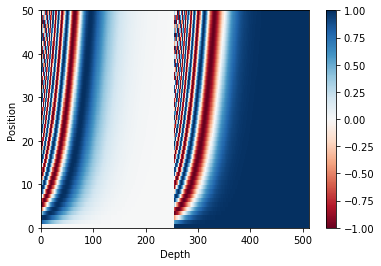

In [17]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoding

**Encoder Layer**

Each encoder layer consists of sublayers:
+ Multi-head attention (with padding mask)
+ 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalisation. Residual connections help in avoiding the vanishing gradient problem in deep networks.

In [18]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

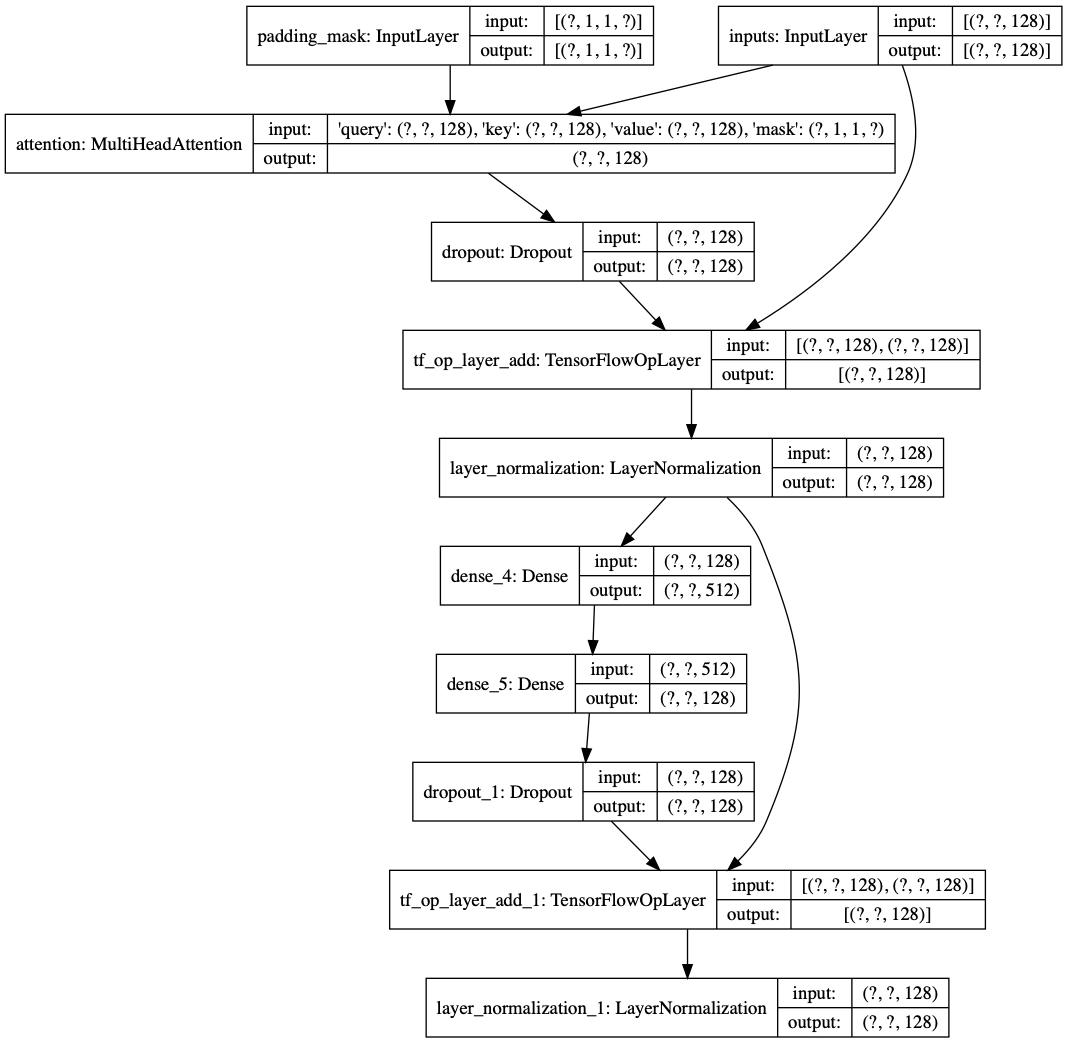

In [19]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")


tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

**Encoder**

The Encoder consists of:
+ Input Embedding
+ Positional Encoding
+ N of encoder layers

The input is put through an embedding, which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [20]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

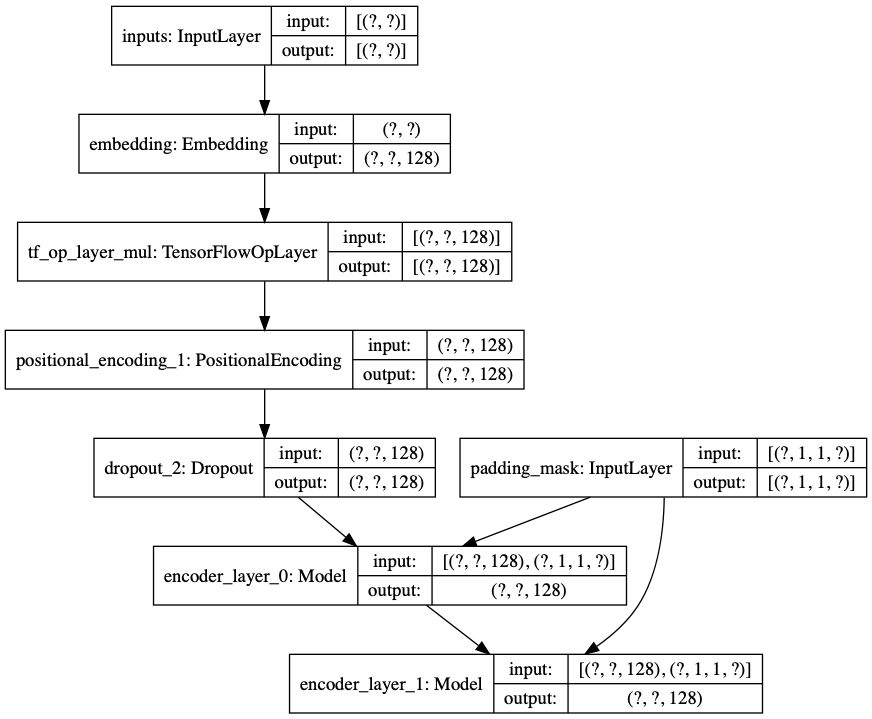

In [21]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoding

**Decoder Layer**

Each decoder layer consists of sublayers:
+ Masked multi-head attention (with look ahead mask and padding mask)
+ Multi-head attention (with padding mask). value and key receive the encoder output as inputs. query receives the output from the masked multi-head attention sublayer.
+ 2 dense layers followed by dropout

As query receives the output from decoder’s first attention block, and key receives the encoder output, the attention weights represent the importance given to the decoder’s input based on the encoder’s output (i.e. the decoder predicts the next word by looking at the encoder output and self-attending to its own output)

In [22]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

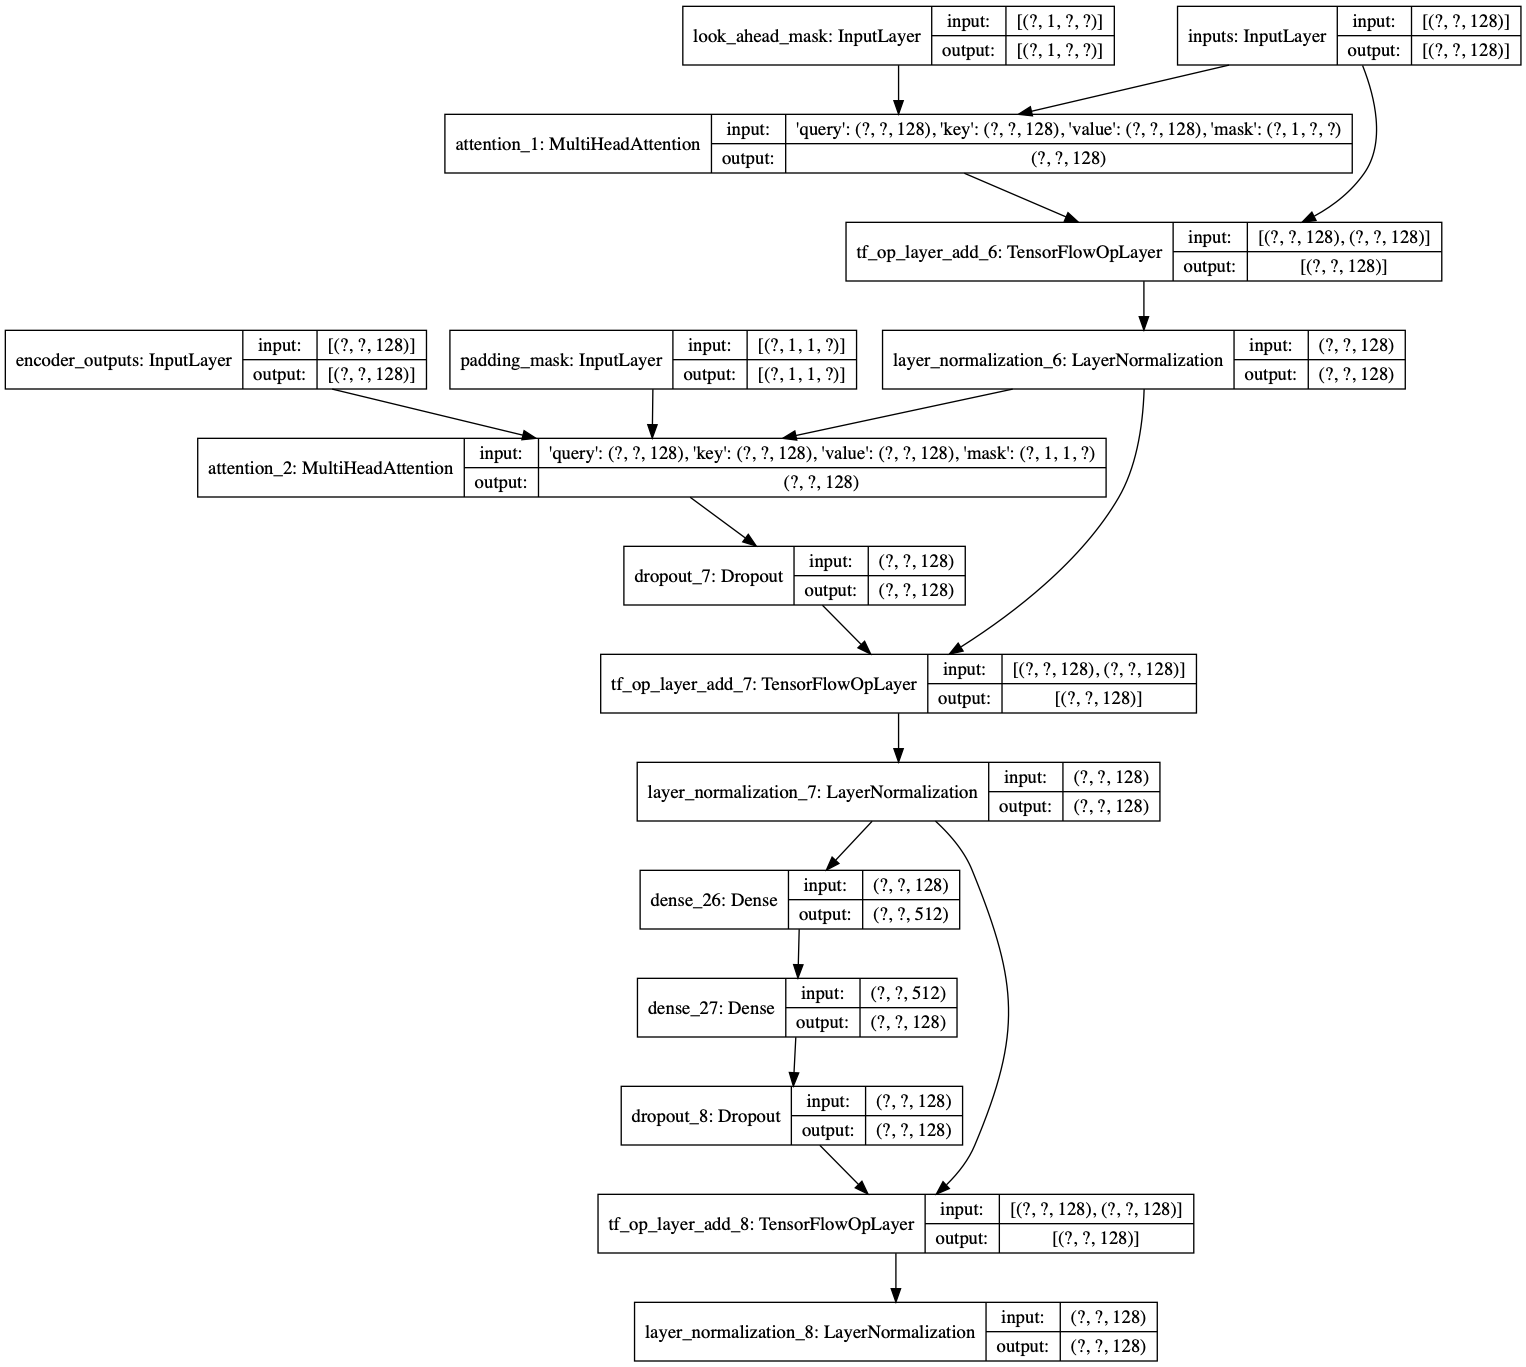

In [23]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

**Decoder**

The Decoder consists of:
+ Output Embedding
+ Positional Encoding
+ N decoder layers

The target is put through an embedding, which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [24]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

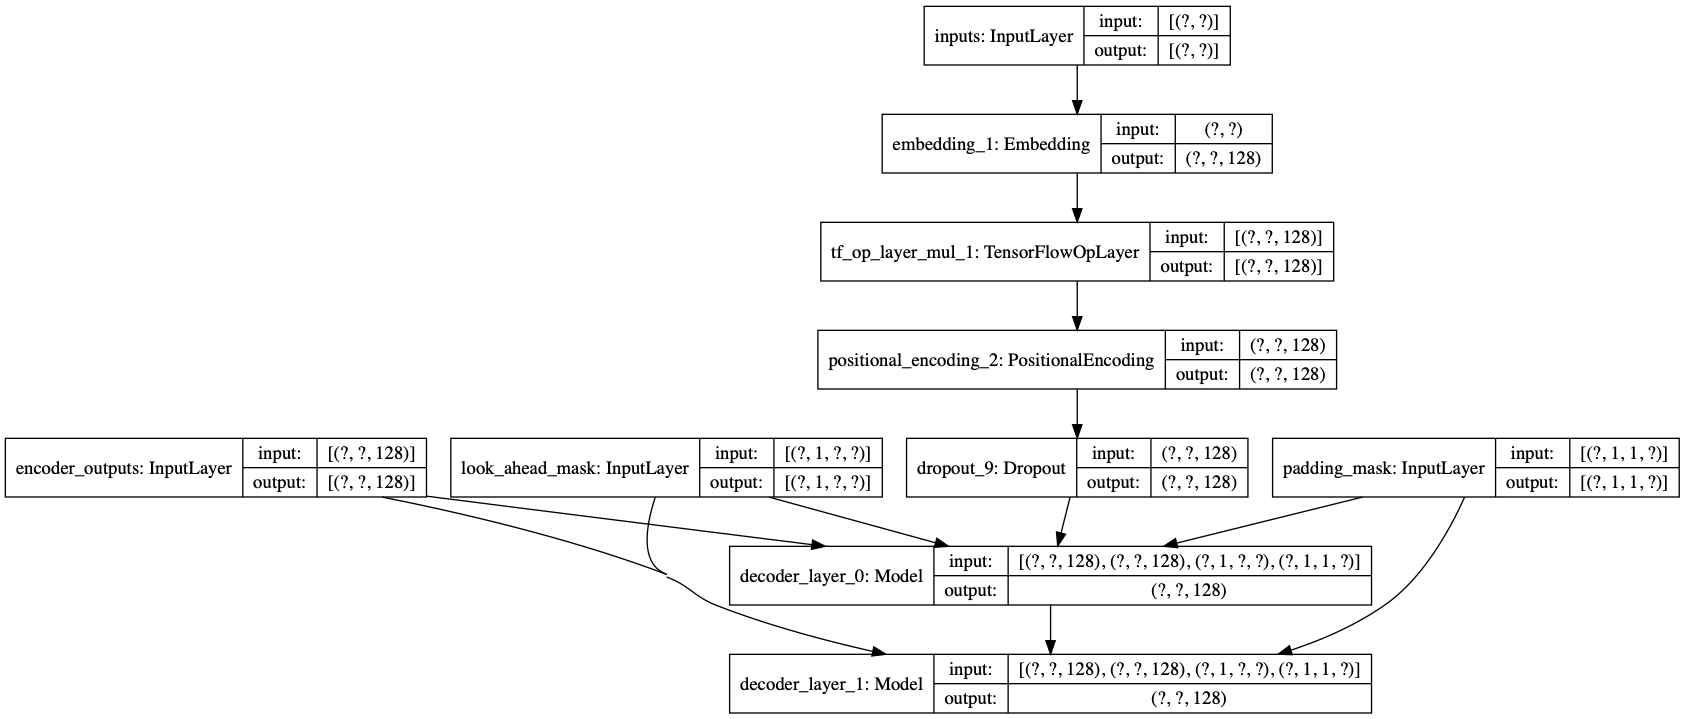

In [25]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

**Transformer**

This consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

enc_padding_mask and dec_padding_mask are used to mask out all the padding tokens. look_ahead_mask is used to mask out future tokens in a sequence. As the length of the masks changes with different input sequence length, we are creating these masks with Lambda layers.

In [26]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    #mask future tokens for decoder inputs at 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    #mask encoder outputs for 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

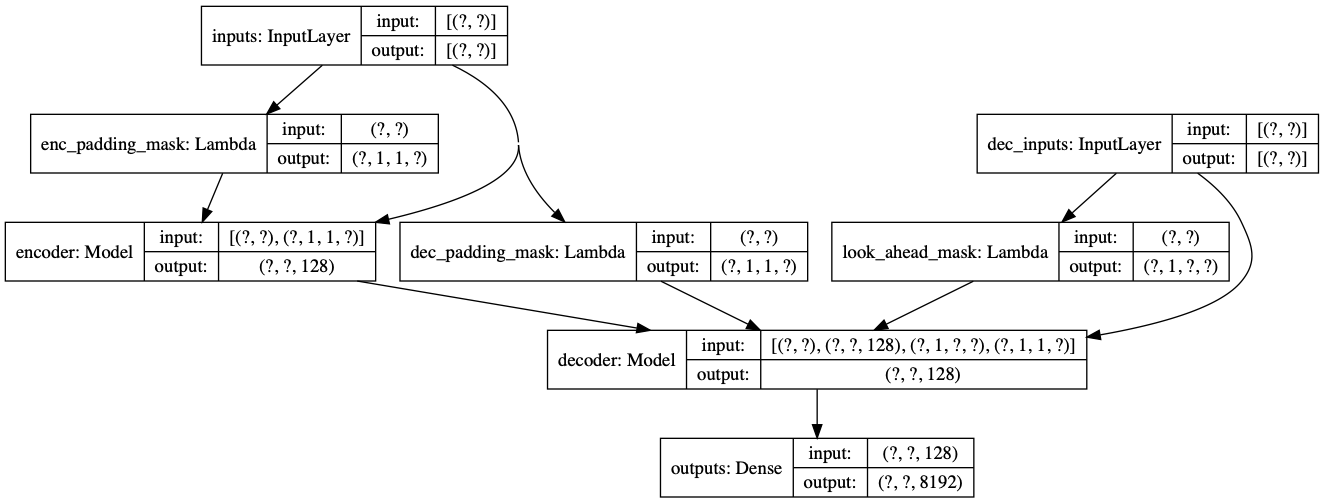

In [27]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## 4. Training the model

**Loss function**

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [28]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

**Custom learning rate**

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

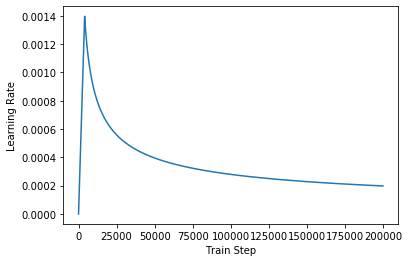

In [30]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

**Initialise and compile model with predefined custom learning rate and Adam optimizer under the strategy scope**

In [31]:
#clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    #ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

#initialise and compile model 
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3140096     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### Fit the model

In [32]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/40
2001/2001 [==============================] - 409s 205ms/step - loss: 2.4100 - accuracy: 0.1199
Epoch 2/40
2001/2001 [==============================] - 412s 206ms/step - loss: 1.9236 - accuracy: 0.1520
Epoch 3/40
2001/2001 [==============================] - 428s 214ms/step - loss: 1.8373 - accuracy: 0.1588
Epoch 4/40
2001/2001 [==============================] - 431s 215ms/step - loss: 1.7599 - accuracy: 0.1650
Epoch 5/40
2001/2001 [==============================] - 414s 207ms/step - loss: 1.7056 - accuracy: 0.1693
Epoch 6/40
2001/2001 [==============================] - 416s 208ms/step - loss: 1.6625 - accuracy: 0.1731
Epoch 7/40
2001/2001 [==============================] - 412s 206ms/step - loss: 1.6271 - accuracy: 0.1766
Epoch 8/40
2001/2001 [==============================] - 414s 207ms/step - loss: 1.5974 - accuracy: 0.1795
Epoch 9/40
2001/2001 [==============================] - 416s 208ms/step - loss: 1.5712 - accuracy: 0.1822
Epoch 10/40
2001/2001 [=======================

## 5. Evaluating and predicting with the model

The following steps are used for evaluation:
+ Apply the same preprocessing method we used to create our dataset for the input sentence.
+ Tokenize the input sentence and add START_TOKEN and END_TOKEN.
+ Calculate the padding masks and the look ahead masks.
+ The decoder then outputs the predictions by looking at the encoder output and its own output.
+ Select the last word and calculate the argmax of that.
+ Concatentate the predicted word to the decoder input as pass it to the decoder.
+ In this approach, the decoder predicts the next word based on the previous words it predicted.

In [33]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        #select last word from seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        #return result if predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        #concatenate predicted_id to output given to decoder as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [34]:
#feed model with its previous output
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
    sentence = predict(sentence)
    print('')

Input: I am not crazy, my mother had me tested.
Output: i m sorry , i didn t mean to be rude .

Input: i m sorry , i didn t mean to be rude .
Output: i m sorry . i m sorry . i m not a very good guy .

Input: i m sorry . i m sorry . i m not a very good guy .
Output: i m sorry . i m not going to let you go .

Input: i m sorry . i m not going to let you go .
Output: i m not interested .

Input: i m not interested .
Output: i know . i know . i know .



In [35]:
for _ in range(5):
    sentence = input('Enter question : ' )
    sentence = predict(sentence)
    print('')

Enter question : I am not crazy, my mother had me tested
Input: I am not crazy, my mother had me tested
Output: i m not interested .

Enter question : that is not very nice
Input: that is not very nice
Output: i m afraid i can t do that .

Enter question : why not
Input: why not
Output: i m not very kind .

Enter question : perhaps you should try to be
Input: perhaps you should try to be
Output: i don t know what you re talking about .

Enter question : me neither
Input: me neither
Output: you don t know me , do you ?

